# Members:
Erik Ström

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget # uncomment this and rerun the notebook if you want to interact with the graphs

In [2]:
# set "resolution" of the figures
plt.rcParams["figure.dpi"] = 100

# 1.

# 1.1 Logistic map
The map is perturbed by alpha * x^2.

For these parameters, interestingly the system

seems to go back and forth between

chaos and stability.

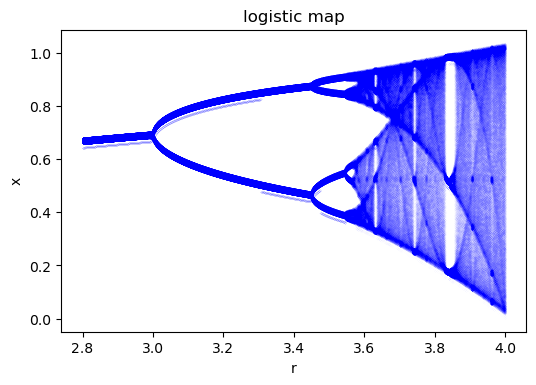

In [3]:
alpha = 0.0000001

interval = (2.8, 4)  # start, end
accuracy = 0.0001
reps = 600  # number of repetitions
numtoplot = 200
lims = np.zeros(reps)

fig, biax = plt.subplots()
#fig.set_size_inches(16, 9)

lims[0] = np.random.rand()
for r in np.arange(interval[0], interval[1], accuracy):
    for i in range(reps-1):
        lims[i+1] = r*lims[i]*(1-lims[i])
        # Adding a mononomial to the map:
        lims[i] += alpha * i**2

    biax.plot([r]*numtoplot, lims[reps-numtoplot:], 'b.', markersize=.01)
    
biax.set(xlabel='r', ylabel='x', title='logistic map')
plt.show()

# 1.2 Bifurcation points & Feigenbaum constants α and β
We know that the Feigenbaum constants are universal (under what conditions?), so we should expect to get similar results

when looking at our bifurcation points here. 

We first measure (very roughly) three points where a period doubling occurs by inspecting the diagram

and calculate the distance between the respective points.

In [4]:
x_1 = 2.9997
x_2 = 3.4474
x_3 = 3.5429

d_1 = x_2 - x_1
d_2 = x_3 - x_2 

feig_a = d_1/d_2
print(f'beta = {feig_a}')

beta = 4.687958115183252


Not exactly the feigenbaum constant but close enough.

the second constant can be estimated in a similar way but instead of the width of the period doubling window we consider the height instead.

# 2

## 2.1 RK integration & Lorenz system
Modified to solve the Lorenz system

and properly plot the attractor.

In [5]:
def Lorenz_system(t, y):
    """
    Lorenz system
    y: state vector [y1, y2]
    t: discrete time step value
    """
    # standard system params
    s = 10. # sigma
    b = 8./3. # beta
    r = 28. # rho
    return np.array([s*(y[1] - y[0]), 
                             r*y[0] - y[1] - y[0]*y[2], 
                            y[0]*y[1] - b*y[2]])

y evaluated at time t = 20.0 seconds: -7.135762399921512


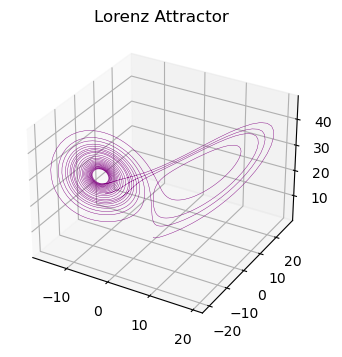

In [6]:
# Runge-Kutta (RK4) Numerical Integration for System of First-Order Differential Equations

def rk4(func, tk, _yk, _dt=0.01, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt), **kwargs)

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)


# ==============================================================
# simulation harness

dt = 0.01

# define interval for RK
start = 1
end = 20
time = np.linspace(start, end, end * 100)

# Lorenz system initial conditions [y1, y2, y3] at t0
y0 = np.array([0., 1., 1.05])

# ==============================================================
# propagate state

# simulation results
state_history = []

# initialize yk
yk = y0

# intialize time
t = 0

# approximate y at time t
for t in time:
    state_history.append(yk)
    yk = rk4(Lorenz_system, t, yk, dt)

# convert list to numpy array
state_history = np.array(state_history)

print(f'y evaluated at time t = {t} seconds: {yk[0]}')

# ==============================================================

# plot solution
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*state_history.T, antialiased = True, color="purple", linewidth=0.3)
ax.set_title("Lorenz Attractor")

plt.show()

## 2.2 Lyapunov exponent

Here we estimate the lyapunov exponent by using the formula

<br>

$ \lambda (x) = \lim_{n \to \infty} \frac{1}{n} \sum_k^{n-1} \ln |f'(x_k)|$

<br>

where the derivative is estimated using the finite difference method (i.e. using the defenition of the derivative) 

and the avarage of the limit is estimated using the samples available in our solution.

In our case, we estimate the gradient in one direction only, though in the 3D case we should probably

be more careful than that.

### Param setup

In [7]:
# rk stepsize
dt = 0.01

# evaluation interval for rk (lyapunov exponent calculations)
start = 1
end = 10000
time = np.linspace(start, end, end * 100)

In [8]:
# Initial condition chosen such that we are in the basin of the attractor
y0 = state_history[-1] 

# define a small separation vector (in our case in one direction) 
epsilon = np.array([0, 0, 1e-10])
# get the length of the vector
epsilon_length = np.linalg.norm(epsilon)

print(f'IC = {y0}\nepsilon = {epsilon}\nepsilon length = {epsilon_length}')

IC = [-6.87649107 -9.431012   21.80018356]
epsilon = [0.e+00 0.e+00 1.e-10]
epsilon length = 1e-10


### Lyapunov estimate

In [9]:
# initialize yk and yk+epsilon
yk = y0

# intialize time
t = 0

# initialize gradient estimate sum to 0
sum_delta_y = 0

# approximate y at time t
for t in time:
    # aproximate f(x+epsilon)
    yk_epsilon = rk4(Lorenz_system, t, (yk + epsilon), dt)
    # approximate f(x)
    yk = rk4(Lorenz_system, t, yk, dt)
    
    # measure the separation (distance) between the orbit and the orbit perturbed by epsilon
    # and then divide by the step-size to get the estimate of the derivative 
    sum_delta_y += np.linalg.norm(yk - yk_epsilon) / epsilon_length

# finally we average the estimates to get our final exponent
lyapunov_exponent = (sum_delta_y / len(time) )

# Print lyapunov exponent
print(f'lyapunov exponent = {lyapunov_exponent}')

lyapunov exponent = 0.9736209886005919


### Result
Since the Lyapunov exponent is constant over the whole system, which in our cases is the Lorenz system with standard parameters, 

we can verify that our result is plausible. The Lyapunov exponent is supposedly around 0.9056 which is fairly close to our estimate where increasing the number of samples should give us a closer estimate.

<br>
The Lyapunov exponent measures the rate of separation between any two infinitesimally close orbits, which means that a positive exponent implies an exponential separation between
any two "close" orbits (though technically, there are supposedly more than one exponent, which probably means the separation is measured along different dimensions?). Because the Lyapunov exponent is constant between any "close" orbits, no orbits can converge in such a system (suppose they did, then at that point they would be "close", but such orbits diverge under our assumption, a contradiction). Thus, any two orbits in such a system, does not converge to any periodic orbit or stationary point. 

Similarly, if the separation between any two nearby orbits decreases on average, then those orbits will converge at the limit (possibly to a stationary point?). 

If the Lyapunov exponent is 0, then we have a constant separation on average between any nearby orbits. This should mean that the system is inherently symettric in some way.

<br>
The rate of separation should give us some idea about the chaoticity of a system. Indeed, if orbits converge quickly or there is some strong symmetry in the system, the system should intuitively not inhibit as much chaoticity as a system with high separation between orbit. Clearly if all orbits converge to a periodic one (or a stationary point), then at the limit the system is not sensitive to initial conditions and should thus not be chaotic (?), wheras for systems with large exponents, however close we choose our initial conditions, we can guarantee that the separation at the limit is as large as indicated by the Lyapunov exponent, though it is not clear if the Lyapunov exponent being positive is a sufficient condition for chaoticity (nor if a negative or a 0 one is sufficient to deem a system non-chaotic, though it probably is).